### Imports necesarios:

In [20]:
import numpy as np  
from sklearn import metrics  
from sklearn.model_selection import cross_val_score
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

## 1. Introduccion
### En este cuaderno vamos a trabajar con los siguientes algoritmos:
* Regresión de Ridge
* ElasticNet
* Regresión Bayesiana
* Lasso
* Quantile Regression
### Para los siguientes datasets:
* Casas de Boston (https://www.kaggle.com/datasets/vikrishnan/boston-house-prices?authuser=0)
* Redimiento de los alumnos (https://www.kaggle.com/datasets/lainguyn123/student-performance-factors?authuser=0)

In [ ]:
## Importamos los datasets
import kagglehub
from kagglehub import KaggleDatasetAdapter

# IMPORTACION HOUSING
housing_path = "Boston.csv"
# Cargar la última versión del dataset
dfhousing = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,  # Formato (Pandas)
  "willianleite/boston-housing-dataset",  # Nombre del dataset
  housing_path
)
# Mostrar las primeras 5 filas del dataset housing
display("DATASET HOUSING",dfhousing.head(5))

# IMPORTACION STUDENT
student_path = "StudentPerformanceFactors.csv"
# Cargar la última versión del dataset
dfstudent = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,  # Formato (Pandas)
  "lainguyn123/student-performance-factors",  # Nombre del dataset
  student_path
)
# Mostrar las primeras 5 filas del dataset student
display("DATASET STUDENT",dfstudent.head(5))

100%|██████████| 37.3k/37.3k [00:00<00:00, 417kB/s]


'DATASET HOUSING'

,Unnamed: 0,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,1,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,2,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,3,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,5,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


'DATASET STUDENT'

,Hours_Studied,Attendance,Parental_Involvement,Access_to_Resources,Extracurricular_Activities,Sleep_Hours,Previous_Scores,Motivation_Level,Internet_Access,Tutoring_Sessions,Family_Income,Teacher_Quality,School_Type,Peer_Influence,Physical_Activity,Learning_Disabilities,Parental_Education_Level,Distance_from_Home,Gender,Exam_Score
0,23,84,Low,High,No,7,73,Low,Yes,0,Low,Medium,Public,Positive,3,No,High School,Near,Male,67
1,19,64,Low,Medium,No,8,59,Low,Yes,2,Medium,Medium,Public,Negative,4,No,College,Moderate,Female,61
2,24,98,Medium,Medium,Yes,7,91,Medium,Yes,2,Medium,Medium,Public,Neutral,4,No,Postgraduate,Near,Male,74
3,29,89,Low,Medium,Yes,8,98,Medium,Yes,1,Medium,Medium,Public,Negative,4,No,High School,Moderate,Male,71
4,19,92,Medium,Medium,Yes,6,65,Medium,Yes,3,Medium,High,Public,Neutral,4,No,College,Near,Female,70


In [7]:
# Borramos la primera columna que es el ID
dfhousing = dfhousing.drop('Unnamed: 0', axis = 1)

### Información Dataset Boston:
* **cim**: Crimen per cápita
* **zn**: Zona residencial
* **indus**: Zona industrial
* **chas**: Río Charles (0/1)
* **nox**: Contaminación NOX
* **rm**: Habitaciones promedio
* **age**: Viviendas antiguas
* **dis**: Distancia empleo
* **rad**: Acceso a carreteras
* **TAX**: Impuesto propiedad
* **ptratio**: Alumnos por maestro
* **black**: Índice población negra
* **lstat**: % población baja
* **medv**: Valor medio viviendas (Esta va a ser nuestra variable objetivo)

### Información Dataset Estudiantes:
* **Hours_Studied:** Horas de estudio
* **Attendance:** Asistencia (%)
* **Parental_Involvement:** Involucramiento parental
* **Access_to_Resources:** Acceso a recursos
* **Extracurricular_Activities:** Actividades extracurriculares
* **Sleep_Hours:** Horas de sueño
* **Previous_Scores:** Puntajes previos
* **Motivation_Level:** Nivel de motivación
* **Internet_Access:** Acceso a internet
* **Tutoring_Sessions:** Tutorías mensuales
* **Family_Income:** Ingreso familiar
* **Teacher_Quality:** Calidad docente
* **School_Type:** Tipo de escuela
* **Peer_Influence:** Influencia de pares
* **Physical_Activity:** Actividad física
* **Learning_Disabilities:** Dificultades de aprendizaje
* **Parental_Education_Level:** Educación parental
* **Distance_from_Home:** Distancia a la escuela
* **Gender:** Género
* **Exam_Score:** Puntaje final (Esta va a ser nuestra variable objetivo)

### Funciones para las métricas a utilizar:
* **MAE**: Promedio del error absoluto entre valores reales y predichos.
* **MSE**: Promedio de los errores elevados al cuadrado, penaliza grandes errores.
* **RMSE**: Raíz cuadrada del MSE, mide el error en la misma escala que los datos.
* **R²**: Proporción de varianza explicada por el modelo, indica su precisión.
* **R²** Ajustado: R² corregido por el número de variables, evita sobreajuste.
* **RMSLE**: Mide el error logarítmico, penaliza más las diferencias en valores bajos.
* **VC**: Promedio de la validación cruzada, mide la estabilidad del modelo.

In [ ]:
def Reg_Models_Evaluation_Metrics (model,X_train,y_train,X_test,y_test,y_pred):
      
    
    # Número de registros en el dataset
    n = X_test.shape[0]
    # Número de columnas en el dataset
    p = X_test.shape[1]
    
    
    MAE = metrics.mean_absolute_error(y_test,y_pred)
    MSE = metrics.mean_squared_error(y_test,y_pred)
    RMSE = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    R2 = model.score(X_test, y_test)
    R2_AJUSTADO = 1-(1-R2)*(n-1)/(n-p-1)
    RMSLE = metrics.mean_squared_log_error(y_test,y_pred)
    #cv son las iteraciones
    validacion_cruzada_errores = cross_val_score(estimator = model, X = X_train, y = y_train, cv = 10)
    #obtenemos el promedio
    VC = validacion_cruzada_errores.mean()
    
    print('MAE:', round(MAE,4))
    print('MSE:', round(MSE,4))
    print('RMSE:', round(RMSE,4))
    print('R2:', round(R2,4))
    print('R2 AJUSTADO:', round(R2_AJUSTADO,4))
    print('RMSLE:', round(RMSLE, 4) )
    print('VC:', round(VC, 4) )
    return MAE,MSE,RMSE,R2,R2_AJUSTADO,RMSLE,VC

### Funcion para la distribucion de las variables

In [13]:
# Comprobar distribuciones
def dist_custom(dataset, columns_list, rows, cols, suptitle):
    fig, axs = plt.subplots(rows, cols,figsize=(16,16))
    fig.suptitle(suptitle,y=1, size=25)
    axs = axs.flatten()
    for i, data in enumerate(columns_list):
        sns.kdeplot(dataset[data], ax=axs[i], fill=True,  alpha=.5, linewidth=0)
        axs[i].set_title(data + ', skewness is '+str(round(dataset[data].skew(axis = 0, skipna = True),2)))

## 1.1 Limpieza de los dataset
### trataremos los datos antes de aplicar los modelos en todos los datasets: 
* Limpiar datos
* Codificacion
* Escalado

### DATASET BOSTON

In [8]:
display("DATASET BOSTON",dfhousing.head(5))

'DATASET BOSTON'

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


### A simple vista no se puede ver nada para limpiar en los datos ni codificar, solo que hay valores muy desescalados que habrá que escalar antes de aplicar cada algoritmo, está todo en numérico, vamos a ver si hay valores nulos:

In [10]:
dfhousing.isnull().sum()

crim       0
zn         0
indus      0
chas       0
nox        0
rm         0
age        0
dis        0
rad        0
tax        0
ptratio    0
black      0
lstat      0
medv       0
dtype: int64

In [11]:
### miramos el schema por si son todos numéricos realmente
dfhousing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   crim     506 non-null    float64
 1   zn       506 non-null    float64
 2   indus    506 non-null    float64
 3   chas     506 non-null    int64  
 4   nox      506 non-null    float64
 5   rm       506 non-null    float64
 6   age      506 non-null    float64
 7   dis      506 non-null    float64
 8   rad      506 non-null    int64  
 9   tax      506 non-null    int64  
 10  ptratio  506 non-null    float64
 11  black    506 non-null    float64
 12  lstat    506 non-null    float64
 13  medv     506 non-null    float64
dtypes: float64(11), int64(3)
memory usage: 55.5 KB


In [19]:
dfhousing.describe()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


### Vamos a ver la distribucion de las variables para tenerlas en cuenta para el escalado

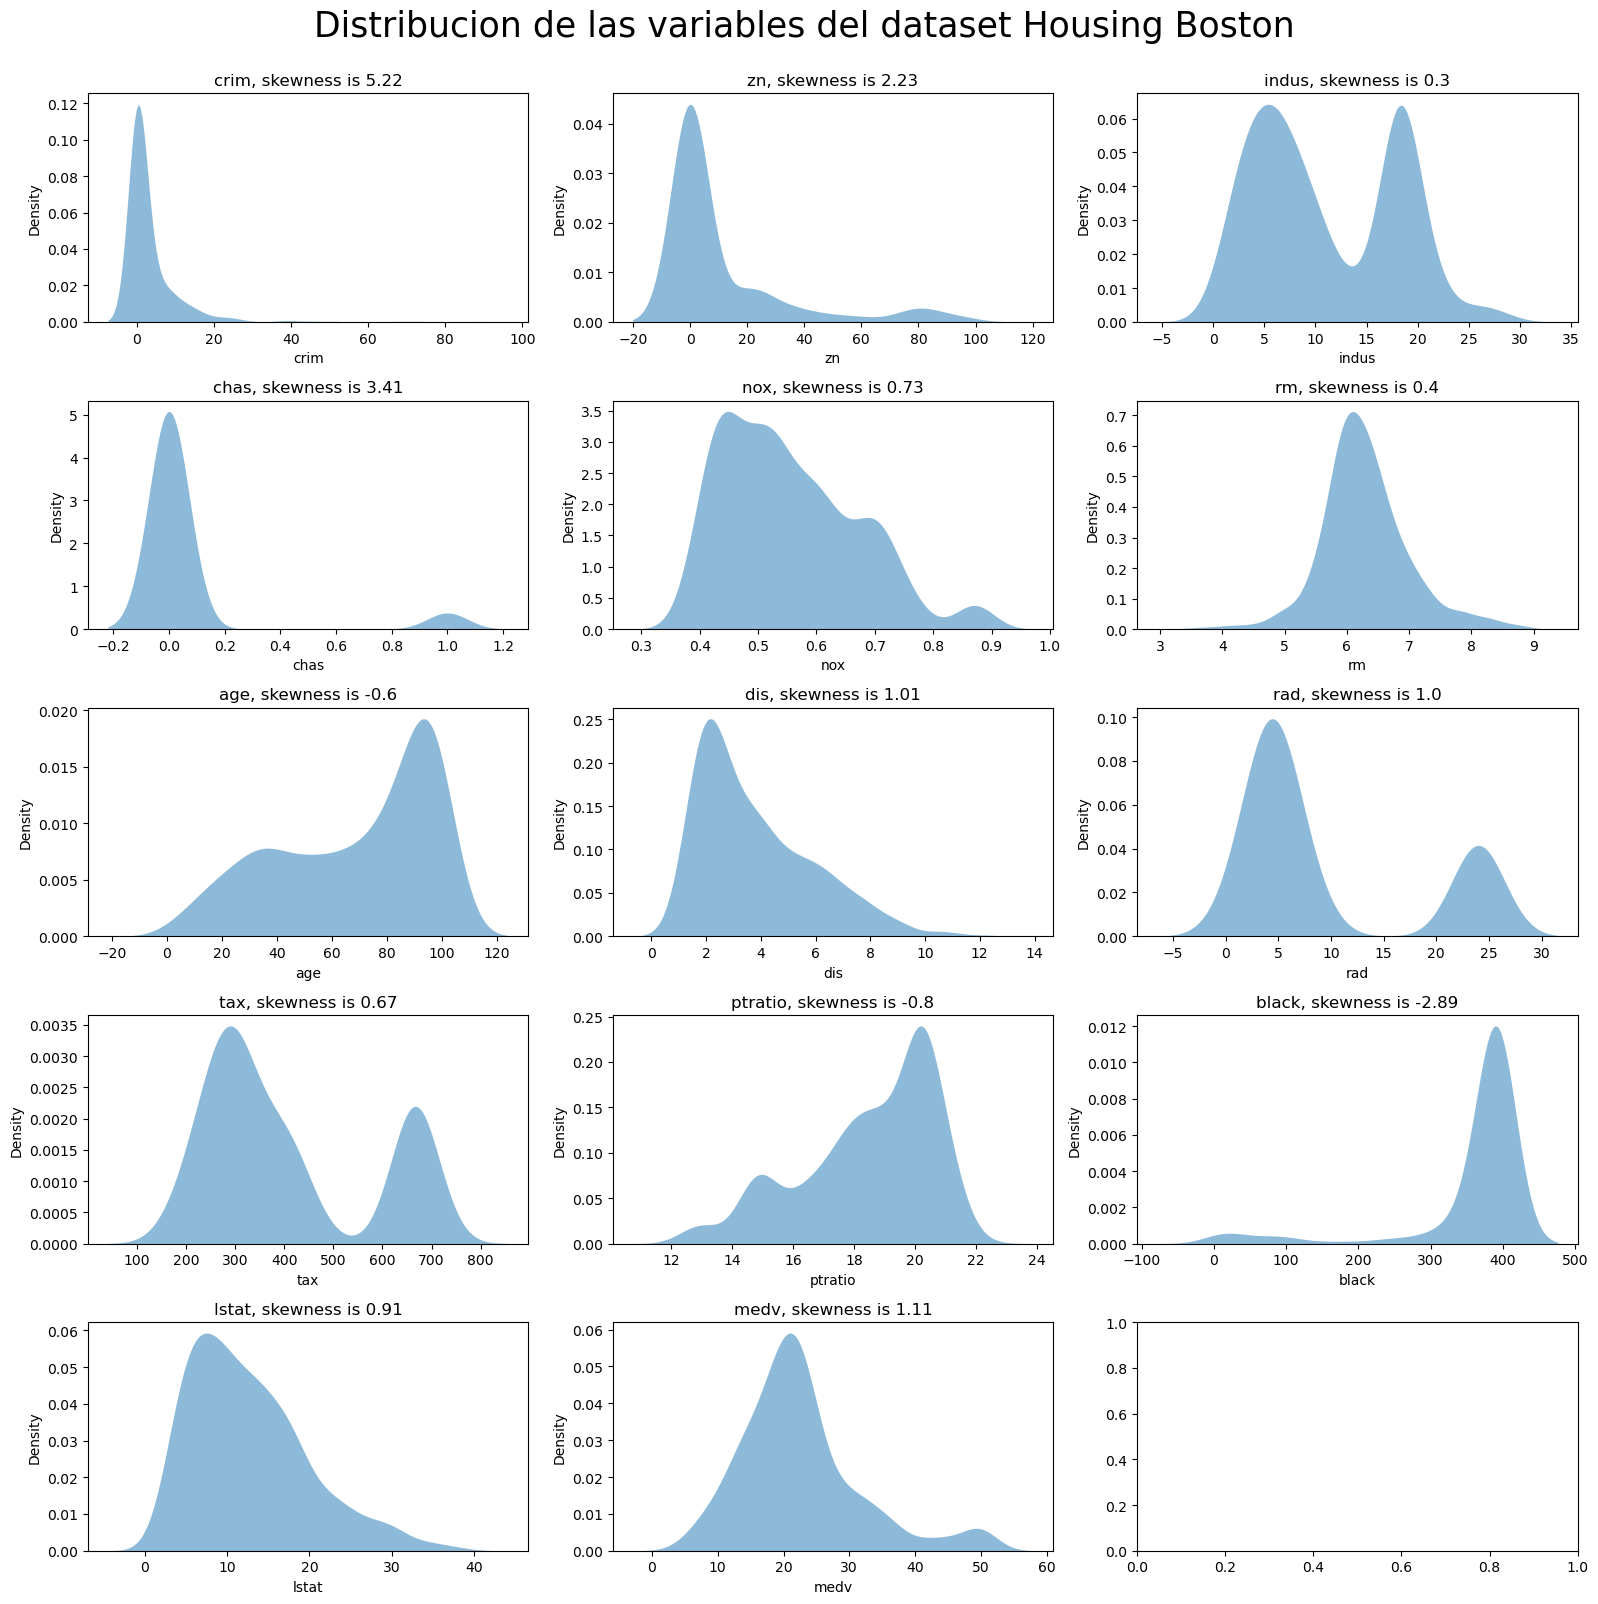

In [18]:
numeric_columns = ["crim", "zn", "indus", "chas", "nox", "rm", "age", "dis", "rad", "tax", "ptratio", "black", "lstat", "medv"]
dist_custom(dfhousing, columns_list=numeric_columns, rows=5, cols=3, suptitle='Distribucion de las variables del dataset Housing Boston')
plt.tight_layout()

### Escalado variables (Conclusión de la distribución)

| Variable | Escalado         | Justificación                      |
|----------|-----------------|------------------------------------|
| crim     | RobustScaler    | Valores atípicos altos.     |
| zn       | MinMaxScaler    | Rango entre 0 y 100.              |
| indus    | StandardScaler  | Distribución casi normal.         |
| chas     | No escalar      | Variable binaria.                 |
| nox      | StandardScaler  | Distribución casi normal.         |
| rm       | StandardScaler  | Ligera asimetría, pero normal.    |
| age      | StandardScaler  | Distribución casi normal.         |
| dis      | RobustScaler    | Valores atípicos altos.           |
| rad      | RobustScaler    | Distribución muy sesgada.         |
| tax      | RobustScaler    | Valores atípicos y asimetría.     |
| ptratio  | StandardScaler  | Distribución casi normal.         |
| black    | MinMaxScaler    | Valores en un rango fijo.         |
| lstat    | StandardScaler  | Ligera asimetría, pero normal.    |
| medv     | No escalar      | Variable objetivo.                |

In [21]:
# Escaladores
scalers = {
    "RobustScaler": RobustScaler(),
    "MinMaxScaler": MinMaxScaler(),
    "StandardScaler": StandardScaler()
}

# Columnas y escalador
scaling_dict = {
    "crim": "RobustScaler",
    "zn": "MinMaxScaler",
    "indus": "StandardScaler",
    "nox": "StandardScaler",
    "rm": "StandardScaler",
    "age": "StandardScaler",
    "dis": "RobustScaler",
    "rad": "RobustScaler",
    "tax": "RobustScaler",
    "ptratio": "StandardScaler",
    "black": "MinMaxScaler",
    "lstat": "StandardScaler"
}

# Aplicamos el escalado
scaled_features = {}
for col, scaler_name in scaling_dict.items():
    scaler = scalers[scaler_name]
    scaled_features[col] = scaler.fit_transform(dfhousing[[col]])

# Convertir a DataFrame escalado
dfhousing_escalao = dfhousing.copy()
for col in scaled_features:
    dfhousing_escalao[col] = scaled_features[col]

# Mostrar primeras filas
dfhousing_escalao.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,-0.069593,0.18,-1.287909,0,-0.144217,0.413672,-0.120013,0.285777,-0.20,-0.087855,-1.459000,1.000000,-1.075562,24.0
1,-0.063755,0.00,-0.593381,0,-0.740262,0.194274,0.367166,0.569789,-0.15,-0.227390,-0.303094,1.000000,-0.492439,21.6
2,-0.063760,0.00,-0.593381,0,-0.740262,1.282714,-0.265812,0.569789,-0.15,-0.227390,-0.303094,0.989737,-1.208727,34.7
3,-0.062347,0.00,-1.306878,0,-0.835284,1.016303,-0.809889,0.924391,-0.10,-0.279070,0.113032,0.994276,-1.361517,33.4
4,-0.052144,0.00,-1.306878,0,-0.835284,1.228577,-0.511180,0.924391,-0.10,-0.279070,0.113032,1.000000,-1.026501,36.2


### DATASET ESTUDIANTES

In [5]:
display("DATASET STUDENT",dfstudent.head(5))

'DATASET STUDENT'

,Hours_Studied,Attendance,Parental_Involvement,Access_to_Resources,Extracurricular_Activities,Sleep_Hours,Previous_Scores,Motivation_Level,Internet_Access,Tutoring_Sessions,Family_Income,Teacher_Quality,School_Type,Peer_Influence,Physical_Activity,Learning_Disabilities,Parental_Education_Level,Distance_from_Home,Gender,Exam_Score
0,23,84,Low,High,No,7,73,Low,Yes,0,Low,Medium,Public,Positive,3,No,High School,Near,Male,67
1,19,64,Low,Medium,No,8,59,Low,Yes,2,Medium,Medium,Public,Negative,4,No,College,Moderate,Female,61
2,24,98,Medium,Medium,Yes,7,91,Medium,Yes,2,Medium,Medium,Public,Neutral,4,No,Postgraduate,Near,Male,74
3,29,89,Low,Medium,Yes,8,98,Medium,Yes,1,Medium,Medium,Public,Negative,4,No,High School,Moderate,Male,71
4,19,92,Medium,Medium,Yes,6,65,Medium,Yes,3,Medium,High,Public,Neutral,4,No,College,Near,Female,70


## 2. Regresión de Ridge

## 3. ElesticNet

## 4. Regresión Bayesiana

## 5. Lasso

## 6. Quantile Regression